In [2]:
import jax
jax.config.update("jax_default_device",jax.devices()[-1])
jax.config.update("jax_enable_x64", True)
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false'
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *

In [39]:
#u_data = jnp.load("darcy_example_data/u_vals.npy")
x_grid=jnp.linspace(0,1,100)
y_grid=jnp.linspace(0,1,100)
X,Y=jnp.meshgrid(x_grid,y_grid)

def u_true_function1(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(1*(jnp.cos(2*x) + jnp.cos(3*y))))

def u_true_function2(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(0.2 * (jnp.sin(1*(jnp.cos(5*x) - jnp.cos(4*y)))))

def u_true_function3(xy):
    x = xy[0]
    y = xy[1]
    return jnp.sin(2 * x) * jnp.cos(3 * y)

def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

u_true_functions = [u_true_function1,u_true_function2,u_true_function3]
rhs_funcs = [jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]
u_true_functions = [jax.vmap(u) for u in u_true_functions]

In [40]:
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [49]:
xy_int,xy_bdy = build_xy_grid((0,1),(0,1),100,100)

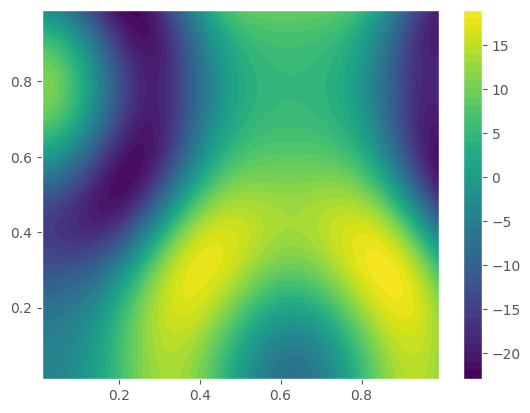

In [52]:
plt.tricontourf(xy_int[:,0],xy_int[:,1],rhs_funcs[1](xy_int),50)
plt.colorbar()